In [75]:
import os
import cv2
import csv
import torch
import numpy as np
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt

from cv2 import Mat
from glob import glob
from collections import namedtuple
from kornia_moons.viz import draw_LAF_matches


In [76]:
device = torch.device('cuda')
matcher = KF.LoFTR()
matcher = matcher.to(device).eval()

In [77]:
# Helper functions

# named tuple to hold: Kalibration Rotation Translation
Gt = namedtuple('Gt', ['K', 'R', 'T'])

# A very small number
eps = 1e-15

def get_tensor_from_np(img: Mat, device, re_scale=840) -> (torch.Tensor, float, float):
    """ given image and rescale, calculates scale factor. resizing and converting to tensor.
    returns the tensor together with the scales to transpose back to original scale. """
    scale = re_scale / max(img.shape[0], img.shape[1])
    h = int(img.shape[0] * scale)
    w = int(img.shape[1] * scale)
    scale_h = h / img.shape[0]
    scale_w = w / img.shape[1]
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, keepdim=False).float() / 255
    #img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float() / 255.
    
    # cv2 imread, converted image to BGR. here we transform to RGB.
    # img = K.color.bgr_to_rgb(img)
    return img.to(device), scale_h, scale_w


def get_loftr_matches(img1, img2, matcher):
    """ Given img1, img2 and matcher (which is LoFTR torch.model)
    returns the matching key points 0, 1, and confidence by LoFTR. """
    input_dict = {
        "image0": K.color.rgb_to_grayscale(img1),
        "image1": K.color.rgb_to_grayscale(img2),
    }
    with torch.no_grad():
        correspondences = matcher(input_dict)

    mkpts0 = correspondences['keypoints0']
    mkpts1 = correspondences['keypoints1']
    conf = correspondences['confidence']

    return mkpts0, mkpts1, conf




In [78]:
# Given functions doing hardcore linear algebra 

def NormalizeKeypoints(keypoints, K):
    C_x = K[0, 2]
    C_y = K[1, 2]
    f_x = K[0, 0]
    f_y = K[1, 1]
    keypoints = (keypoints - np.array([[C_x, C_y]])) / np.array([[f_x, f_y]])
    return keypoints


def ComputeEssentialMatrix(F, K1, K2, kp1, kp2):
    '''Compute the Essential matrix from the Fundamental matrix, given the calibration matrices. 
    Note that we ask participants to estimate F, i.e., without relying on known intrinsics.'''

    # Some shit about old opencv ransac versions returns Y x 3 matrices where Y != 3
    assert F.shape[0] == 3, 'Malformed F?'

    # Use OpenCV's recoverPose to solve the cheirality check:
    # https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0
    E = np.matmul(np.matmul(K2.T, F), K1).astype(np.float64)

    kp1n = NormalizeKeypoints(kp1, K1)
    kp2n = NormalizeKeypoints(kp2, K2)
    # Probably using SVD to decompose R and T.
    num_inliers, R, T, mask = cv2.recoverPose(E, kp1n, kp2n)

    return E, R, T


def QuaternionFromMatrix(matrix):
    '''Transform a rotation matrix into a quaternion.'''

    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    m00 = M[0, 0]
    m01 = M[0, 1]
    m02 = M[0, 2]
    m10 = M[1, 0]
    m11 = M[1, 1]
    m12 = M[1, 2]
    m20 = M[2, 0]
    m21 = M[2, 1]
    m22 = M[2, 2]

    K = np.array(
        [[m00 - m11 - m22, 0.0, 0.0, 0.0],
         [m01 + m10, m11 - m00 - m22, 0.0, 0.0],
         [m02 + m20, m12 + m21, m22 - m00 - m11, 0.0],
         [m21 - m12, m02 - m20, m10 - m01, m00 + m11 + m22]]
    )
    K /= 3.0

    # The quaternion is the eigenvector of K that corresponds to the largest eigenvalue.
    w, V = np.linalg.eigh(K)
    q = V[[3, 0, 1, 2], np.argmax(w)]

    if q[0] < 0:
        np.negative(q, q)

    return q


def ComputeErrorForOneExample(q_gt, T_gt, q, T, scale):
    '''Compute the error metric for a single example.
    
    The function returns two errors, over rotation and translation.
    These are combined at different thresholds by ComputeMaa in order to compute the mean Average Accuracy.'''
    
    q_gt_norm = q_gt / (np.linalg.norm(q_gt) + eps)
    q_norm = q / (np.linalg.norm(q) + eps)

    loss_q = np.maximum(eps, (1.0 - np.sum(q_norm * q_gt_norm)**2))
    err_q = np.arccos(1 - 2 * loss_q)

    # Apply the scaling factor for this scene.
    T_gt_scaled = T_gt * scale
    T_scaled = T * np.linalg.norm(T_gt) * scale / (np.linalg.norm(T) + eps)

    err_t = min(np.linalg.norm(T_gt_scaled - T_scaled), np.linalg.norm(T_gt_scaled + T_scaled))

    return err_q * 180 / np.pi, err_t


def LoadCalibration(filename):
    '''Load calibration data (ground truth) from the csv file.'''
    
    calib_dict = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header.
            if i == 0:
                continue

            camera_id = row[1]
            K = np.array([float(v) for v in row[2].split(' ')]).reshape([3, 3])
            R = np.array([float(v) for v in row[3].split(' ')]).reshape([3, 3])
            T = np.array([float(v) for v in row[4].split(' ')])
            calib_dict[camera_id] = Gt(K=K, R=R, T=T)
    
    return calib_dict

In [74]:
# Might remove this code.. wtf is this doing? :>
data_src = '../data/cv-22928-2025-a-project/train'

val_scenes = []
for f in os.scandir(data_src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "brandenburg_gate"" at ../data/cv-22928-2025-a-project/train\brandenburg_gate
Found scene "british_museum"" at ../data/cv-22928-2025-a-project/train\british_museum
Found scene "buckingham_palace"" at ../data/cv-22928-2025-a-project/train\buckingham_palace
Found scene "colosseum_exterior"" at ../data/cv-22928-2025-a-project/train\colosseum_exterior
Found scene "lincoln_memorial_statue"" at ../data/cv-22928-2025-a-project/train\lincoln_memorial_statue
Found scene "notre_dame_front_facade"" at ../data/cv-22928-2025-a-project/train\notre_dame_front_facade
Found scene "pantheon_exterior"" at ../data/cv-22928-2025-a-project/train\pantheon_exterior
Found scene "sacre_coeur"" at ../data/cv-22928-2025-a-project/train\sacre_coeur
Found scene "sagrada_familia"" at ../data/cv-22928-2025-a-project/train\sagrada_familia
Found scene "taj_mahal"" at ../data/cv-22928-2025-a-project/train\taj_mahal
Found scene "temple_nara_japan"" at ../data/cv-22928-2025-a-project/train\temple_nara_japan
Fo

Loaded 75 images.


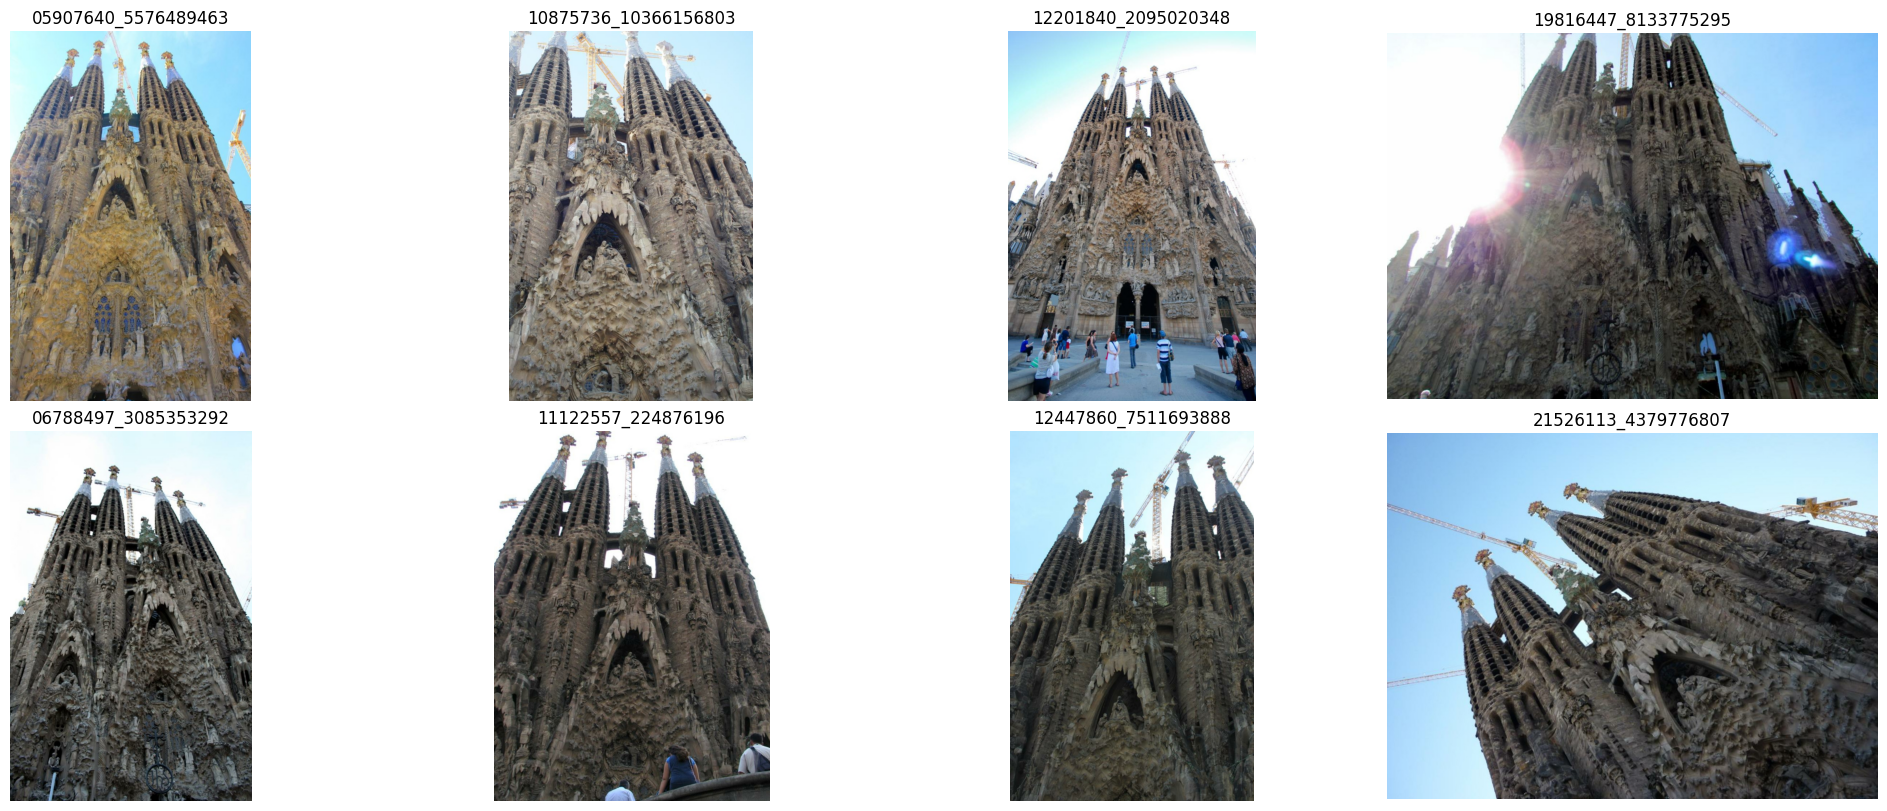

In [94]:
# Picking scene, print some of it's images
scene = 'sagrada_familia'

images_dict = {}
for filename in glob(f'{data_src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 2
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

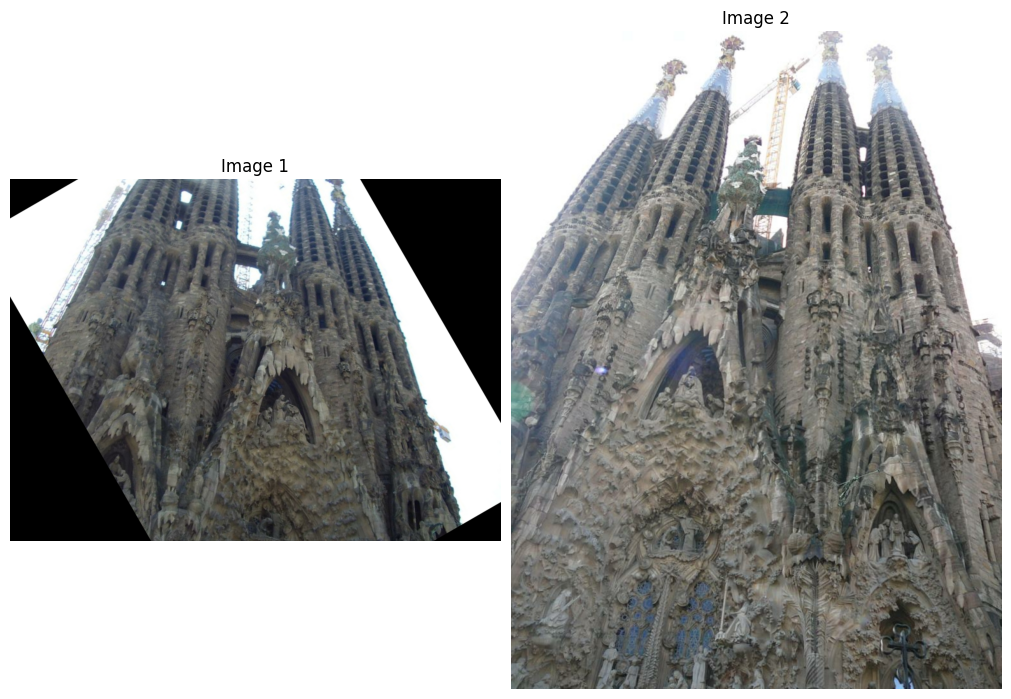

In [103]:
# Choosing 2 images from that scene, print them. match them. plot their matches, and plot their inliers. 
image_1_id = "77972670_214814210"
image_2_id = "64223960_5316591967"

img_1 = cv2.cvtColor(cv2.imread(f'{data_src}/{scene}/images/{image_1_id}.jpg'), cv2.COLOR_BGR2RGB)

(h, w) = img_1.shape[:2]

# Calculate the center of the image
center = (w // 2, h // 2)

# Define the rotation matrix
angle = -60  # Negative for clockwise rotation
scale = 1.0  # Keep the scale unchanged
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

inverse_angle = -angle  # Reverse the angle
inverse_rotation_matrix = cv2.getRotationMatrix2D(center, inverse_angle, 1.0)

# Perform the rotation
img_1 = cv2.warpAffine(img_1, rotation_matrix, (w, h))

img_2 = cv2.cvtColor(cv2.imread(f'{data_src}/{scene}/images/{image_2_id}.jpg'), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)
axes[0].imshow(img_1)
axes[0].axis('off')
axes[0].set_title("Image 1")  
axes[1].imshow(img_2)
axes[1].axis('off') 
axes[1].set_title("Image 2")
plt.show()


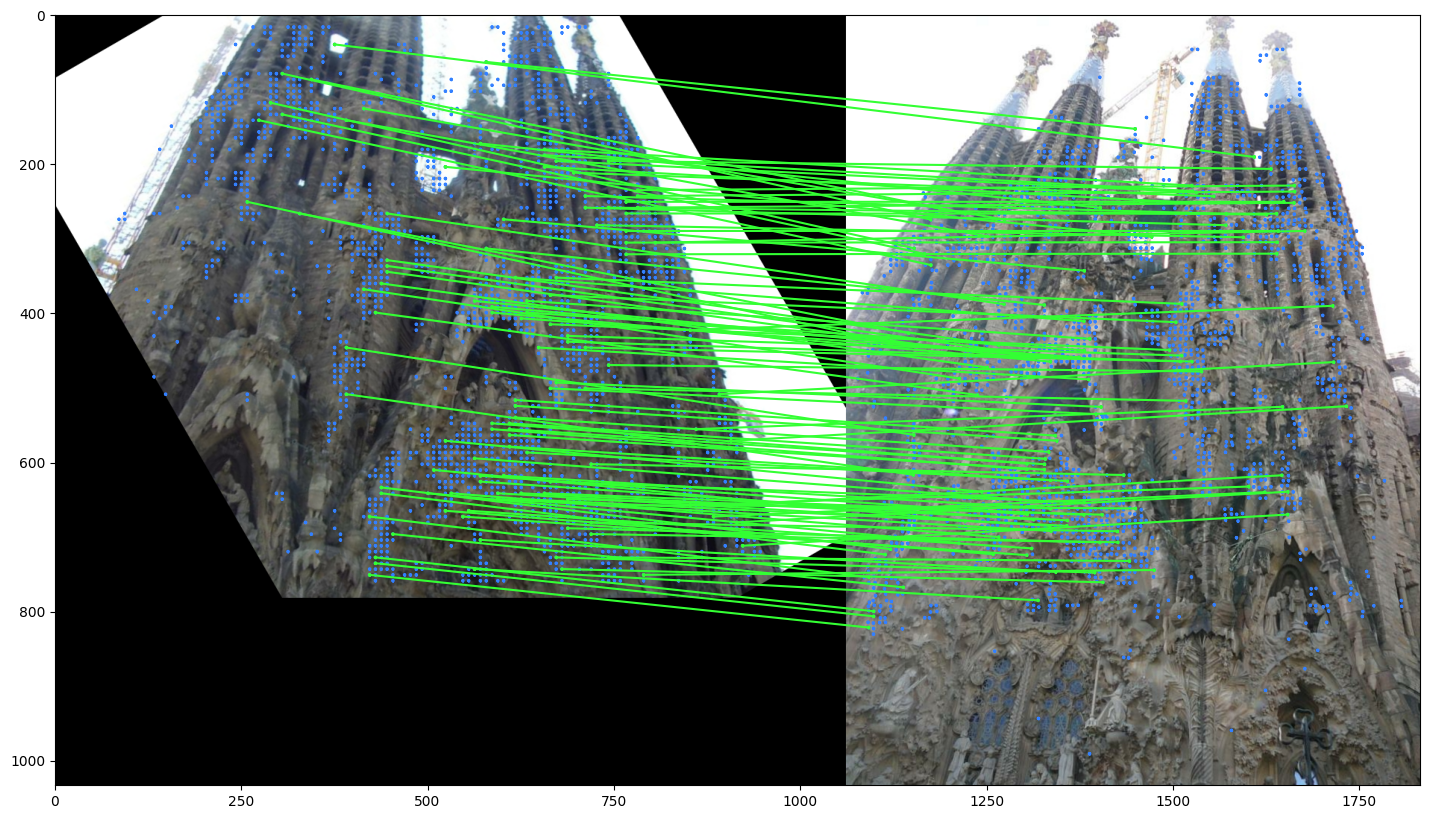

In [111]:
image_1, img1_h_scale, img1_w_scale = get_tensor_from_np(img_1, device, 1080)
image_2, img2_h_scale, img2_w_scale = get_tensor_from_np(img_2, device, 1080)

mkpts0, mkpts1, conf = get_loftr_matches(image_1, image_2, matcher)

# transforming points to original scale
mkpts0[:, 0] /= img1_h_scale
mkpts0[:, 1] /= img1_w_scale
mkpts1[:, 0] /= img2_h_scale
mkpts1[:, 1] /= img2_w_scale

mask = conf > 0.1
mkpts1 = mkpts1[mask].cpu().numpy()
mkpts0 = mkpts0[mask].cpu().numpy()

mkpts0_for_draw = mkpts0

# Rotate the keypoints back!
# Add a third column (z=1) for affine transformation of keypoints
keypoints_rotated_homogeneous = np.hstack([mkpts0, np.ones((mkpts0.shape[0], 1))])
# Transform the keypoints back to the original coordinates
mkpts0 = (inverse_rotation_matrix @ keypoints_rotated_homogeneous.T).T

F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.9999, 100000)

draw_LAF_matches(
            KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0_for_draw).view(1, -1, 2),
                                         torch.ones(mkpts0_for_draw.shape[0]).view(1, -1, 1, 1),
                                         torch.ones(mkpts0_for_draw.shape[0]).view(1, -1, 1)),

            KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1, -1, 2),
                                         torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
                                         torch.ones(mkpts1.shape[0]).view(1, -1, 1)),
            torch.arange(mkpts0_for_draw.shape[0]).view(-1, 1).repeat(1, 2),
            img_1,
            img_2,
            inliers,
            draw_dict={'inlier_color': (0.2, 1, 0.2),
                       'tentative_color': None,
                       'feature_color': (0.2, 0.5, 1), 'vertical': False})



In [112]:
# Calculate the error of the F matrix
# 
calib_dict = LoadCalibration(f'{data_src}/{scene}/calibration.csv')
print(f'Loded ground truth data for {len(calib_dict)} images')

scaling_dict = {}
with open(f'{data_src}/scaling_factors.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        scaling_dict[row[1]] = float(row[2])

print(f'Got {len(scaling_dict)} scaling factors.')

E, R, T = ComputeEssentialMatrix(F, calib_dict[image_1_id].K, calib_dict[image_2_id].K, mkpts0, mkpts1)
q = QuaternionFromMatrix(R)
T = T.flatten()

R1_gt, T1_gt = calib_dict[image_1_id].R, calib_dict[image_1_id].T.reshape((3, 1))
R2_gt, T2_gt = calib_dict[image_2_id].R, calib_dict[image_2_id].T.reshape((3, 1))
dR_gt = np.dot(R2_gt, R1_gt.T)
dT_gt = (T2_gt - np.dot(dR_gt, T1_gt)).flatten()
q_gt = QuaternionFromMatrix(dR_gt)
q_gt = q_gt / (np.linalg.norm(q_gt) + eps)

err_q, err_t = ComputeErrorForOneExample(q_gt, dT_gt, q, T, scaling_dict[scene])
print(f'\nPair "{image_1_id}-{image_2_id}, \nrotation_error={err_q:.02f} (deg) \ntranslation_error={err_t:.02f} (m)', flush=True)

Loded ground truth data for 75 images
Got 12 scaling factors.

Pair "77972670_214814210-64223960_5316591967, 
rotation_error=0.66 (deg) 
translation_error=0.73 (m)
